In [ ]:
graph()
state
edges
nodes
invoke
stategraph()

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph

class MyState(TypedDict, total=False):
    input: str
    output1: str
    output2: str

def function1(state: MyState) -> dict:
    return {"output1": state["input"] + " from function1"}

def function2(state: MyState) -> dict:
    return {"output2": state["output1"] + " and then function2"}

workflow = StateGraph(MyState)
workflow.add_node("function1", function1)
workflow.add_node("function2", function2)
workflow.add_edge("function1", "function2")
workflow.set_entry_point("function1")
workflow.set_finish_point("function2")
app = workflow.compile()

result = app.invoke({"input": "Hi Anuj"})
print(result)

{'input': 'Hi Anuj', 'output1': 'Hi Anuj from function1', 'output2': 'Hi Anuj from function1 and then function2'}


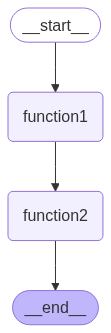

In [99]:
display(Image(app.get_graph().draw_mermaid_png()))

In [101]:
for output in app.stream({"input": "Hi Anuj"}):
    for key,value in output.items():
        print(f"Here is the output from {key}")
        print("___________________________")
        print(value)
        print("\n")

Here is the output from function1
___________________________
{'output1': 'Hi Anuj from function1'}


Here is the output from function2
___________________________
{'output2': 'Hi Anuj from function1 and then function2'}




In [105]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [106]:
model.invoke("hi").content

'Hi there! How can I help you today?'

In [130]:
# State schema
class MyState(TypedDict, total=False):
    input: str
    output: str
    token_count: str

In [131]:
# LLM node
def llm(state: MyState) -> dict:
    model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
    question = state["input"]
    output = model.invoke(question)
    return {"output": output.content}

# Token counter node
def token_counter(state: MyState) -> dict:
    tokens = state["output"].split()
    token_number = len(tokens)
    return {"token_count": f"Total token number in the generated answer is {token_number}"}


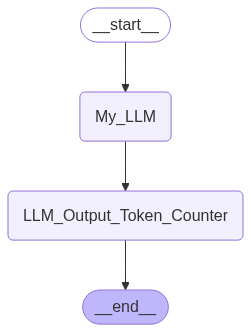

In [132]:
# Build graph
workflow2 = StateGraph(MyState)
workflow2.add_node("My_LLM", llm)
workflow2.add_node("LLM_Output_Token_Counter", token_counter)
workflow2.add_edge("My_LLM", "LLM_Output_Token_Counter")
workflow2.set_entry_point("My_LLM")
workflow2.set_finish_point("LLM_Output_Token_Counter")
display(Image(app.get_graph().draw_mermaid_png()))

In [133]:
# Compile and run
app = workflow2.compile()
result = app.invoke({"input": "What is the capital of India?"})
print(result)

{'input': 'What is the capital of India?', 'output': 'The capital of India is **New Delhi**.', 'token_count': 'Total token number in the generated answer is 7'}


In [135]:
for output in app.stream({"input": "tell me about the tata enterpirse in very detail."}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from My_LLM
_______
{'output': "Tata Enterprises is not a single entity but a massive conglomerate, officially known as the Tata Group.  Understanding it requires looking at its structure, history, key businesses, philosophy, and impact.\n\n**I. History and Structure:**\n\nThe Tata Group's origins trace back to 1868 when Jamsetji Tata founded the Tata & Sons trading company in Bombay (now Mumbai), India.  From humble beginnings in textiles, it diversified aggressively over the decades, driven by a vision of nation-building and social responsibility.  The group's structure is unique:\n\n* **Holding Company:** Tata Sons is the principal investment holding company, owning stakes in various Tata operating companies.  It's not a publicly traded company; its ownership is complex, with trusts playing a significant role in ensuring long-term strategic direction and preventing short-term profit-maximizing decisions.\n* **Operating Companies:**  The group comprises numerous indepe